<a href="https://colab.research.google.com/github/xunzxe/first-repository/blob/master/Main_quest/Quest01/01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 전설의 포켓몬을 찾는 모델 학습하기
___
### 개요
포켓몬의 이름, 속성, 또는 공격력이나 방어력 등과 같은 스탯 값만을 가지고 전설의 포켓몬인지 아닌지를 구별하는 모델을
훈련해보고자 한다.
___
### 목차
##### STEP 1. 데이터 살펴보기
##### STEP 2. 데이터 전처리하기
##### STEP 3. 모델 학습하기
___
### 회고
모델의 성능을 평가하는 지표를 잘 선택하는 것이 중요하다는 것을 알 수 있었다. 정확도가 모델의 성능을 평가하는 지표 중 하나이기도 하지만, 불균형한 데이터를 가지고 있을 때에는 모델의 성능을 정확하게 평가하기 힘들 수도 있다는 것을 알게 되엇다.
___

##STEP 1. 데이터 살펴보기
___

###라이브러리 가져오기

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Jupyter Notebook에서 그래프를 더 선명하게 표시하기 위한 매직 명령어
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

###데이터셋을 pandas로 불러오기
- #: 포켓몬 Id number. 성별이 다르지만 같은 포켓몬인 경우 등은 같은 #값을 가진다. `int`
- Name : 포켓몬 이름. 포켓몬 각각의 이름으로 저장되고, 800개의 포켓몬의 이름 데이터는 모두 다르다. (unique) `str`
- Type 1 : 첫 번째 속성. 속성을 하나만 가지는 경우 Type 1에 입력된다. `str`
- Type 2 : 두 번째 속성. 속성을 하나만 가지는 포켓몬의 경우 Type 2는 NaN(결측값)을 가진다. `str`
- Total : 전체 6가지 스탯의 총합. `int`
- HP : 포켓몬의 체력. `int`
- Attack : 물리 공격력. (scratch, punch 등) `int`
- Defense : 물리 공격에 대한 방어력. `int`
- Sp. Atk : 특수 공격력. (fire blast, bubble beam 등) `int`
- Sp. Def : 특수 공격에 대한 방어력. `int`
- Speed : 포켓몬 매치에 대해 어떤 포켓몬이 먼저 공격할지를 결정. (더 높은 포켓몬이 먼저 공격한다) `int`
- Generation : 포켓몬의 세대. 현재 데이터에는 6세대까지 있다. `int`
- Legendary : 전설의 포켓몬 여부. !! Target feature !! `bool`

In [5]:
original_data = pd.read_csv('Pokemon.csv')
pokemon = original_data.copy()
print(pokemon.shape)
pokemon.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


### 데이터 분류하기

(65, 13)
(735, 13)


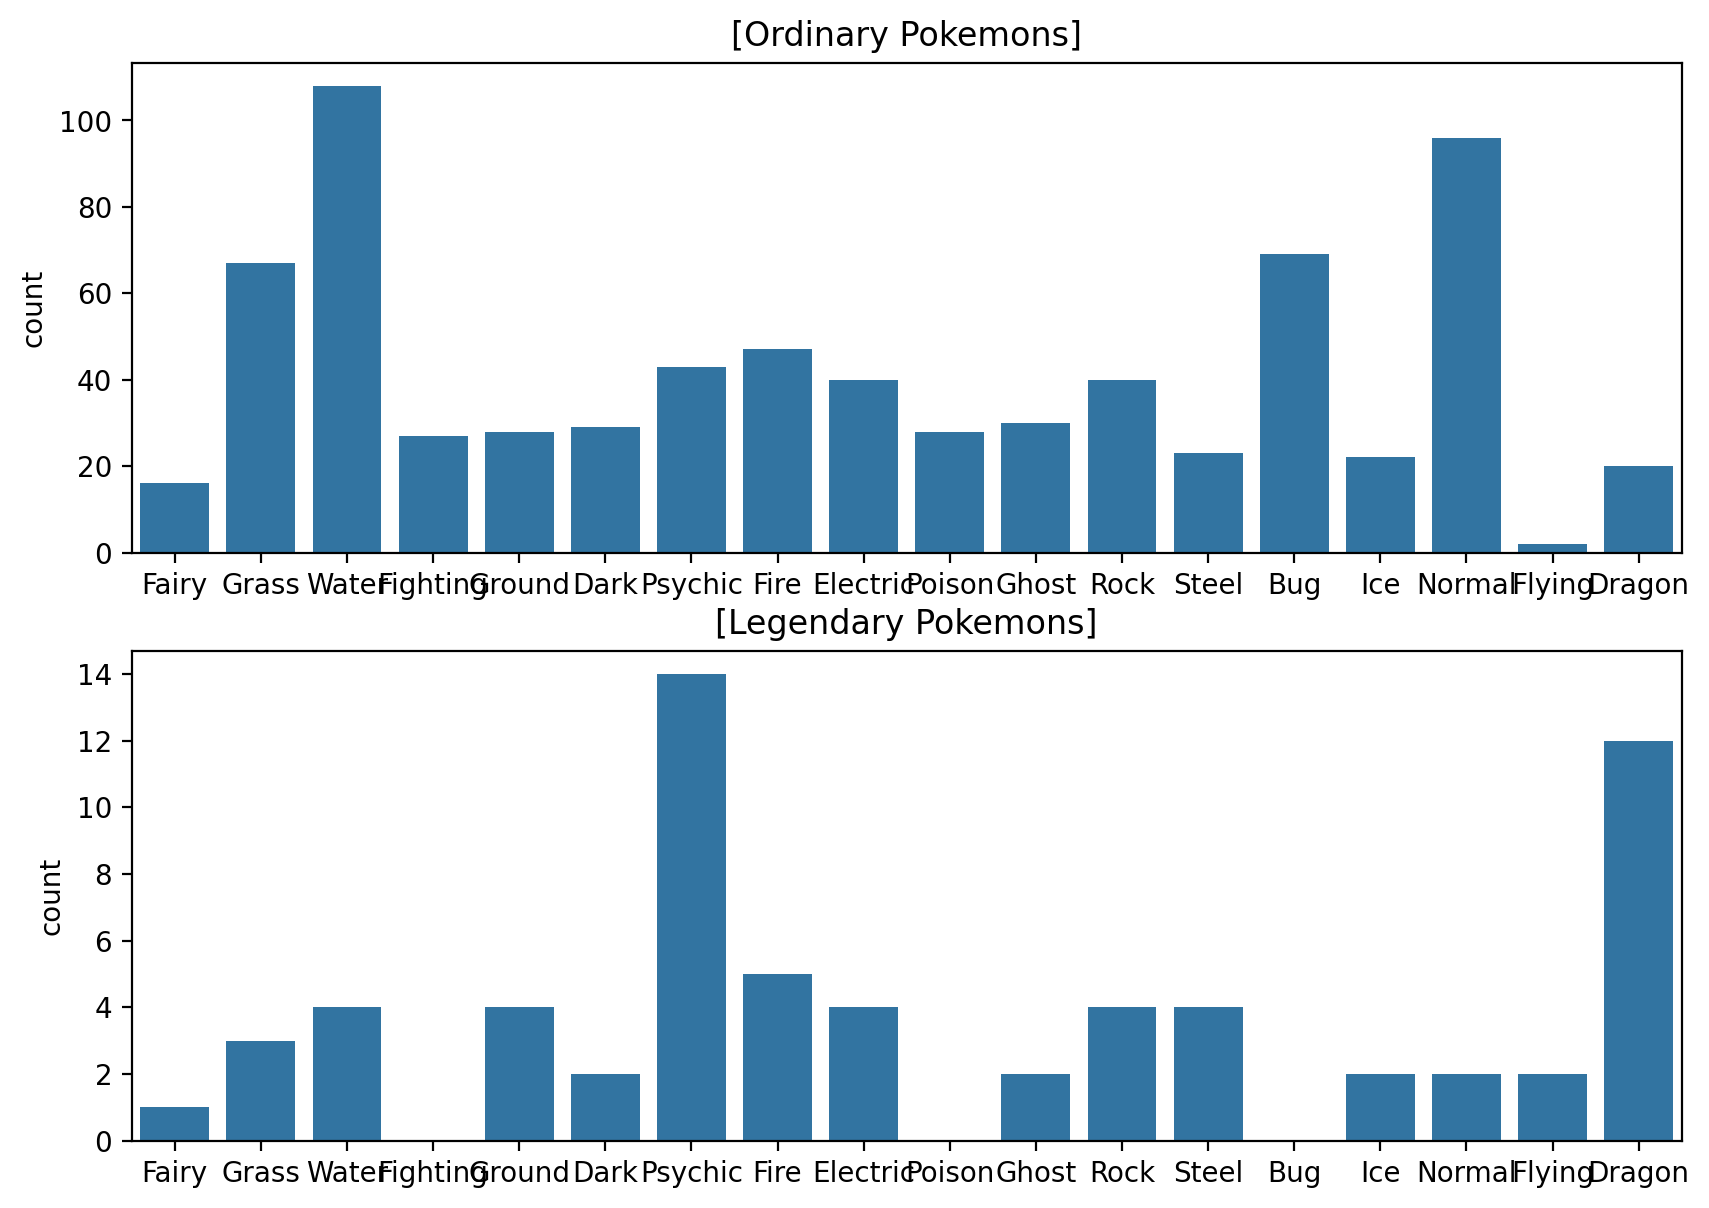

In [6]:
# 전설의 포켓몬 데이터셋
legendary = pokemon[pokemon["Legendary"] == True].reset_index(drop=True)
print(legendary.shape)
legendary.head()

# 일반 포켓몬 데이터셋
ordinary = pokemon[pokemon["Legendary"] == False].reset_index(drop=True)
print(ordinary.shape)
ordinary.head()

types = list(set(pokemon["Type 1"]))
plt.figure(figsize=(10, 7))

# 일반 포켓몬 속성 분포
plt.subplot(211)
sns.countplot(data=ordinary, x="Type 1", order=types).set_xlabel('')
plt.title("[Ordinary Pokemons]")

# 전설의 포켓몬 속성 분포
plt.subplot(212)
sns.countplot(data=legendary, x="Type 1", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

###결측치 확인
포켓몬이 가지는 속성은 기본적으로 하나, 또는 최대 두 개까지 가질 수 있는 것을 알 수 있다. 특히, 데이터셋에서 한 개의 속성을 가지는 포켓몬은 Type 1에만 속성이 표시되고 Type 2에는 NaN값이 들어가 있다. 따라서 Type 2에서 결측치가 확인된다.
-> 총 386개의 포켓몬은 속성을 하나만 가지고, 나머지는 두 개의 속성을 가진다!

In [7]:
pokemon.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

## STEP 2. 데이터 전처리하기
___

In [10]:
# 길이가 10 이상인 이름 추출하기
pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))
pokemon["long_name"] = pokemon["name_count"] >= 10
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True


In [15]:
# 이름에 자주 쓰이는 토큰 추출하기

# 이름이 알파벳으로 이뤄지도록 변경
pokemon = pokemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pokemon = pokemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pokemon = pokemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pokemon = pokemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pokemon = pokemon.replace(to_replace="Porygon2", value="Porygon Two")
pokemon = pokemon.replace(to_replace="Ho-oh", value="Ho Oh")
pokemon = pokemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pokemon = pokemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pokemon = pokemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

# 공백 제거 알파벳으로 이루어져 있는지 확인
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
print(pokemon[pokemon["name_isalpha"] == False].shape)
pokemon[pokemon["name_isalpha"] == False]

import re
from collections import Counter

# 한 개의 이름을 토큰화하는 함수 설정하기
def tokenize(name):
    tokens = []
    for part_name in name.split(" "):
        a = re.findall('[A-Z][a-z]*', part_name)
        tokens.extend(a)

    return np.array(tokens)

#전설의 포켓몬의 이름 토큰화
all_tokens = list(legendary["Name"].apply(tokenize).values)

token_set = []
for token in all_tokens:
    token_set.extend(token)

print(len(set(token_set)))
print(token_set)
most_common = Counter(token_set).most_common(10)
for token, _ in most_common:
    pokemon[f"{token}"] = pokemon["Name"].str.contains(token)

pokemon.head(10)

(0, 27)
65
['Articuno', 'Zapdos', 'Moltres', 'Mewtwo', 'Mewtwo', 'Mega', 'Mewtwo', 'X', 'Mewtwo', 'Mega', 'Mewtwo', 'Y', 'Raikou', 'Entei', 'Suicune', 'Lugia', 'Ho', 'Regirock', 'Regice', 'Registeel', 'Latias', 'Latias', 'Mega', 'Latias', 'Latios', 'Latios', 'Mega', 'Latios', 'Kyogre', 'Kyogre', 'Primal', 'Kyogre', 'Groudon', 'Groudon', 'Primal', 'Groudon', 'Rayquaza', 'Rayquaza', 'Mega', 'Rayquaza', 'Jirachi', 'Deoxys', 'Normal', 'Forme', 'Deoxys', 'Attack', 'Forme', 'Deoxys', 'Defense', 'Forme', 'Deoxys', 'Speed', 'Forme', 'Uxie', 'Mesprit', 'Azelf', 'Dialga', 'Palkia', 'Heatran', 'Regigigas', 'Giratina', 'Altered', 'Forme', 'Giratina', 'Origin', 'Forme', 'Darkrai', 'Shaymin', 'Land', 'Forme', 'Shaymin', 'Sky', 'Forme', 'Arceus', 'Victini', 'Cobalion', 'Terrakion', 'Virizion', 'Tornadus', 'Incarnate', 'Forme', 'Tornadus', 'Therian', 'Forme', 'Thundurus', 'Incarnate', 'Forme', 'Thundurus', 'Therian', 'Forme', 'Reshiram', 'Zekrom', 'Landorus', 'Incarnate', 'Forme', 'Landorus', 'Therian

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,...,Forme,Mega,Mewtwo,Kyurem,Deoxys,Hoopa,Latias,Latios,Kyogre,Groudon
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,False,False,False,False,False,False,False,False,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,False,False,False,False,False,False,False,False,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,False,False,False,False,False,False,False,False,False,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,False,True,False,False,False,False,False,False,False,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,False,False,False,False,False,False,False,False,False,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,False,False,False,False,False,False,False,False,False,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,...,False,False,False,False,False,False,False,False,False,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,...,False,True,False,False,False,False,False,False,False,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,...,False,True,False,False,False,False,False,False,False,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# 속성 데이터 원-핫 인코딩하기
for t in types:
    pokemon[t] = (pokemon["Type 1"] == t) | (pokemon["Type 2"] == t)

pokemon[[["Type 1", "Type 2"] + types][0]].head()

,Type 1,Type 2,Fairy,Grass,Water,Fighting,Ground,Dark,Psychic,Fire,Electric,Poison,Ghost,Rock,Steel,Bug,Ice,Normal,Flying,Dragon
0,Grass,Poison,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,Grass,Poison,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,Grass,Poison,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,Grass,Poison,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,Fire,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


## STEP 3. 모델 학습하기
___

### 의사 결정 트리(decision tree)
- accuracy : (TN+TP)/(TN+FP+FN+TP)
- recall : TP/(FN+TP)
  - TN (True Negative) : 옳게 판단한 Negative, 즉 일반 포켓몬을 일반 포켓몬이라고 알맞게 판단한 경우입니다.
  - FP (False Positive) : 틀리게 판단한 Positive, 즉 일반 포켓몬을 전설의 포켓몬이라고 잘못 판단한 경우입니다.
  - FN (False Negative) : 틀리게 판단한 Negative, 즉 전설의 포켓몬을 일반 포켓몬이라고 잘못 판단한 경우입니다.
  - TP (True Positive) : 옳게 판단한 Positive, 즉 전설의 포켓몬을 전설의 포켓몬이라고 알맞게 판단한 경우입니다.

  

In [26]:
# 8개의 컬럼들을 학습시킨 모델1 학습하기

# 모델 학습에 사용할 컬럼들 추리기
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
X = original_data[features]

# target 데이터 준비하기
target = "Legendary"
y = original_data[target]

In [28]:
# 데이터 분리하기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# train 데이터로 decision tree모델 학습시키고 test 데이터로 모델의 예측 값 얻기
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#결과 확인하기
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[144,   3],
       [  5,   8]])

- accuracy : (TN+TP)/(TN+FP+FN+TP) = 0.95
- recall : TP/(FN+TP) = 0.62

-> accuracy값은 높지만 recall값은 낮은 것을 확인할 수 있다. 그 이유는 데이터가 불균형하기 때문이다. 전설의 포켓몬 65마리에 비해 일반 포켓몬은 735마리로 크기가 다르다 보니, 800마리를 전부 다 일반 포켓몬으로 예측하더라도, 735마리는 일단 맞히고 들어가게 된다.

In [29]:
# 38개의 컬럼들을 학습시킨 모델2 학습하기

# 모델 학습에 사용할 컬럼들 추리기
features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation',
            'name_count','long_name', 'Forme', 'Mega', 'Mewtwo','Deoxys', 'Kyurem', 'Latias', 'Latios',
            'Kyogre', 'Groudon', 'Hoopa','Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire',
            'Electric','Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']
X = pokemon[features]

# target 데이터 준비하기
target = "Legendary"
y = pokemon[target]


In [30]:
# 데이터 분리하기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# train 데이터로 decision tree모델 학습시키고 test 데이터로 모델의 예측 값 얻기
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



- recall : TP/(FN+TP) = 0.92

-> 약 0.62에 그쳤던 recall값이 무려 0.92로까지 오른 것을 확인할 수 있다.